In [5]:
import random
import torch
from graphviz import Digraph  # 👈 Needed for visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Value:
    """Stores a scalar value and its gradient for autograd"""

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only int/float powers supported"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [7]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=(i != len(nouts)-1)) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [8]:
def test_sanity_check():
    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.tensor([-4.0], dtype=torch.float64, requires_grad=True)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    assert ymg.data == ypt.data.item()
    assert xmg.grad == xpt.grad.item()

def test_more_ops():
    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.tensor([-4.0], dtype=torch.float64, requires_grad=True)
    b = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    assert abs(gmg.data - gpt.data.item()) < tol
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol


In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.append((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, f"{n.data:.4f} | grad={n.grad:.4f}", shape='record')
        if n._op:
            dot.node(uid + n._op, n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [10]:
x = Value(-4.0)
z = 2 * x + 2 + x
y = z.relu() + z * x
y.backward()
draw_dot(y).render('graph', view=True)


'graph.svg'

In [11]:
# Create simple model
model = MLP(3, [4, 4, 1])

# Dummy input
x = [Value(1.0), Value(2.0), Value(3.0)]
y = model(x)

# Do backprop
y.backward()

# Visualize the computation graph
draw_dot(y).render("mlp_graph", view=True)


'mlp_graph.svg'

In [12]:
np.random.seed(1337)
random.seed(1337)

In [13]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [14]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [15]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [16]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.36927933859765383, accuracy 84.0%
step 5 loss 0.31354548191852194, accuracy 86.0%
step 6 loss 0.2814234349772434, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192295, accuracy 91.0%
step 13 loss 0.23090378446402732, accuracy 93.0%
step 14 loss 0.20152151227899445, accuracy 92.0%
step 15 loss 0.2257450627928223, accuracy 93.0%
step 16 loss 0.194479875962041, accuracy 92.0%
step 17 loss 0.21089496199246366, accuracy 93.0%
step 18 loss 0.15983077356303602, accuracy 94.0%
step 19 loss 0.18453748746883922, accuracy 93.0%
step 20 loss 0.1897752285608764, accurac

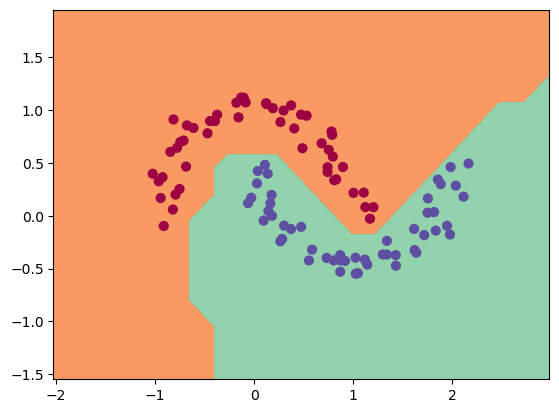

In [19]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.9)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

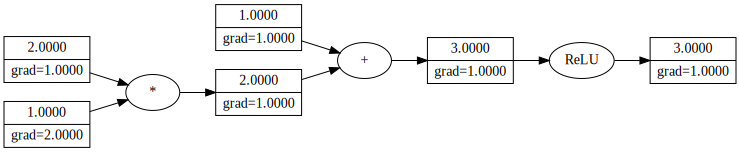

In [20]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

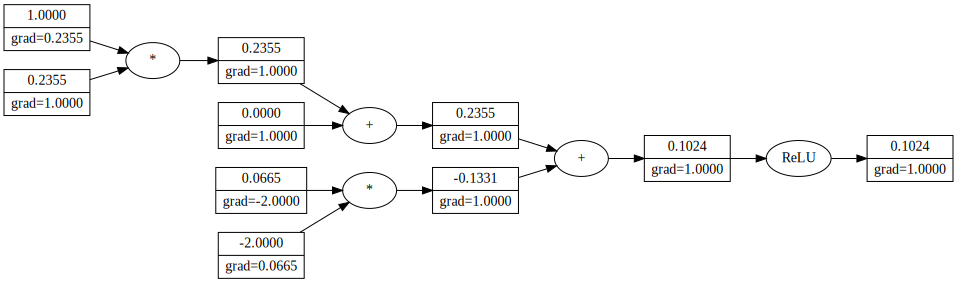

In [27]:
# a simple 2D neuron


random.seed(1337)
n = Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot